# 使用Gluon对CIFAR10进行分类

In [2]:
import mxnet as mx
import numpy as np
import pandas as pd
import utils
import shutil
import os
import logging
logging.basicConfig(level=logging.INFO)

from mxnet import nd
from mxnet import gluon
from mxnet import image 
from mxnet import metric
from mxnet import autograd

%matplotlib inline 
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
import matplotlib.pyplot as plt

mx.random.seed(2018)

## 整理数据

In [3]:
def reorg_cifar10(data_dir, train_dir, test_dir, input_dir, label_file, valid_ratio):
    # 整理label
    with open(os.path.join(data_dir, label_file), 'r') as f:
        label_file = f.readlines()[1:]
        tokens = [l.rstrip().split(',') for l in label_file]
        idx_label = dict((int(idx), label) for idx, label in tokens)
    labels = set(idx_label.values())
    
    # 设置验证集比例
    num_train = len(os.listdir(os.path.join(data_dir, train_dir)))
    num_train_tuning = num_train * (1 - valid_ratio)
    assert 0 < num_train_tuning < num_train
    num_train_tuning_per_label = num_train_tuning // len(labels)
    
    # 整理训练集和验证集
    label_count = dict()
    def mkdir_if_not_exist(path):
        if not os.path.exists(os.path.join(*path)):
            os.makedirs(os.path.join(*path))
            
    for train_file in os.listdir(os.path.join(data_dir, train_dir)):
        idx = int(train_file.split('.')[0])
        train_label = idx_label[idx]
        mkdir_if_not_exist([data_dir, input_dir, 'train_valid', train_label])
        shutil.copy(os.path.join(data_dir, train_dir, train_file),
                   os.path.join(data_dir, input_dir, 'train_valid', train_label))
        # 划分训练集和验证集
        if train_label not in label_count or label_count[train_label] < num_train_tuning_per_label:
            mkdir_if_not_exist([data_dir, input_dir, 'train', train_label])
            shutil.copy(os.path.join(data_dir, train_dir, train_file),
                       os.path.join(data_dir, input_dir, 'train', train_label))
            label_count[train_label] = label_count.get(train_label, 0) + 1
        else:
            mkdir_if_not_exist([data_dir, input_dir, 'valid', train_label])
            shutil.copy(os.path.join(data_dir, train_dir, train_file),
                       os.path.join(data_dir, input_dir, 'valid', train_label))
    
    # 整理测试集
    mkdir_if_not_exist([data_dir, input_dir, 'test', 'unknown'])
    for test_file in os.listdir(os.path.join(data_dir, test_dir)):  
        shutil.copy(os.path.join(data_dir, test_dir, test_file),
                   os.path.join(data_dir, input_dir, 'test', 'unknown'))

In [4]:
data_dir = '../data/kaggle_cifar10'
train_dir = 'train'
test_dir = 'test'
input_dir = 'train_valid_test'
label_file = 'trainLabels.csv'
valid_ratio = .1

if not os.path.exists(os.path.join(data_dir, input_dir, test_dir)):
    reorg_cifar10(data_dir, train_dir, test_dir, input_dir, label_file, valid_ratio)

## 读取数据并增广

In [5]:
train_augs = [
    # 该值为计算得出
    image.ColorNormalizeAug(mean=nd.array([0.4914, 0.4822, 0.4456]), 
                            std=nd.array([0.2023, 0.1994, 0.2010])),
    image.HorizontalFlipAug(.6),
    # image.RandomSizedCropAug((32, 32), 0.8, (0.5, 2))
    # image.BrightnessJitterAug(.5),
    # image.ColorJitterAug
]

test_augs = [
    image.ColorNormalizeAug(mean=nd.array([0.4914, 0.4822, 0.4456]), 
                            std=nd.array([0.2023, 0.1994, 0.2010]))
]

def transform(data, label, augs):
    img = data.astype(np.float32)
    for aug in augs:
        img = aug(img)
    img = img.clip(0, 255).transpose((2,0,1)) / 255
    return img, nd.array([label]).asscalar().astype(np.float32)

############################################################################
def transform_train(data, label):
    im = data.astype('float32') / 255
    im = image.imresize(im, 40, 40)
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0,
                        rand_crop=True, rand_resize=False, rand_mirror=True,
                        mean=np.array([0.4914, 0.4822, 0.4465]),
                        std=np.array([0.2023, 0.1994, 0.2010]),
                        brightness=0, contrast=0,
                        saturation=0, hue=0,
                        pca_noise=0, rand_gray=0, inter_method=2)
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2,0,1))
    return (im, nd.array([label]).asscalar().astype('float32'))

def transform_test(data, label):
    im = data.astype('float32') / 255
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32),
                        mean=np.array([0.4914, 0.4822, 0.4465]),
                        std=np.array([0.2023, 0.1994, 0.2010]))
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2,0,1))
    return (im, nd.array([label]).asscalar().astype('float32'))
############################################################################

input_str = data_dir + '/' + input_dir + '/'

# 读取数据
train_ds = gluon.data.vision.ImageFolderDataset(input_str + 'train', transform=transform_train)
valid_ds = gluon.data.vision.ImageFolderDataset(input_str + 'valid', transform=transform_test)
train_valid_ds = gluon.data.vision.ImageFolderDataset(input_str + 'train_valid', transform=transform_train)
test_ds = gluon.data.vision.ImageFolderDataset(input_str + 'test', transform=transform_test)

batch_size = 64
train_data = gluon.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, last_batch='keep')
valid_data = gluon.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=True, last_batch='keep')
train_valid_data = gluon.data.DataLoader(train_valid_ds, batch_size=batch_size, last_batch='keep')
test_data = gluon.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False, last_batch='keep')

(64, 3, 32, 32)


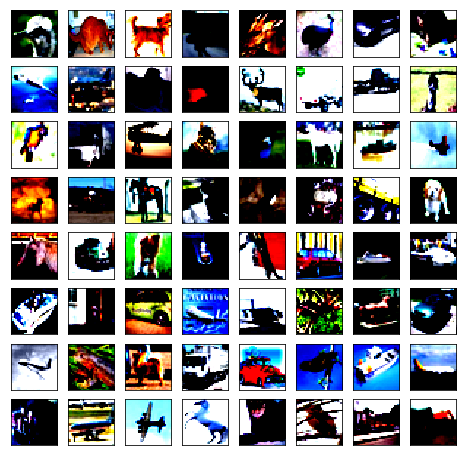

In [6]:
for data, label in valid_data:
    print(data.shape)
    break

utils.show_images(data.transpose((0,2,3,1)), 8, 8, figsize=(8,8))

## SparseNet

论文地址：https://arxiv.org/abs/1801.05895

In [16]:
'''
BN_ReLU_CONV: 非线性单元
'''
def BN_ReLU_CONV(channels, kernel_size, strides=1, padding=0):
    basic = gluon.nn.HybridSequential()
    with basic.name_scope():
        basic.add(
            gluon.nn.BatchNorm(axis=1),
            gluon.nn.Activation('relu'),
            gluon.nn.Conv2D(channels, kernel_size=kernel_size, 
                            strides=strides, padding=padding)
        )
    return basic


'''
SparseUnit: Sparse单元
'''
class SparseUnit(gluon.HybridBlock):
    def __init__(self, channels, bottleneck=False, **kwargs):
        super().__init__(**kwargs)
        # bottleneck unit
        self.bottleneck = bottleneck
        with self.name_scope():
            unit = self.unit = gluon.nn.HybridSequential()
            if self.bottleneck:
                unit.add(BN_ReLU_CONV(channels, kernel_size=1))
            unit.add(BN_ReLU_CONV(channels, kernel_size=3, padding=1))
            
    def hybrid_forward(self, F, X):
        return self.unit(X)

'''
fetch_exponential_idx: 返回列表中的2^k的index
'''
def fetch_exponential_idx(x_list):
    count = len(x_list)
    i = 1    
    inputs = []
    while i <= count:
        inputs.append(x_list[count - i])
        i *= 2
    return inputs

'''
SparseBlock: Sparse block层
'''
class SparseBlock(gluon.HybridBlock):
    def __init__(self, nDenseBlock, growth_rate, bottleneck=False, droprate=.0, **kwargs):
        super().__init__(**kwargs)
        self.nDenseBlock = nDenseBlock
        with self.name_scope():
            net = self.net = gluon.nn.HybridSequential()
            for i in range(nDenseBlock):
                blk = gluon.nn.HybridSequential()
                if bottleneck:
                    interchannels = 4 * growth_rate
                    blk.add(BN_ReLU_CONV(interchannels, kernel_size=1))
                    if droprate > .0:
                        blk.add(gluon.nn.Dropout(droprate)) 
                    blk.add(BN_ReLU_CONV(growth_rate, kernel_size=3, padding=1))
                    if droprate > .0:
                        blk.add(gluon.nn.Dropout(droprate)) 
                else:
                    blk.add(BN_ReLU_CONV(growth_rate, kernel_size=3, padding=1))
                    if droprate > .0:
                        blk.add(gluon.nn.Dropout(droprate)) 
                net.add(blk)
        
    def hybrid_forward(self, F, X):
        X_list = [X]
        for i, blk in enumerate(self.net):
            X = blk(X)
            X_list.append(X)
            expidx_output = fetch_exponential_idx(X_list)
            
            # concat
            tmp = expidx_output[0] 
            for out in expidx_output[1:]:
                tmp = F.concat(tmp, out, dim=1)
            X = tmp
        print('SparseBlk - ', X.shape)
        return X

'''
TransitionLayer: 过渡层
'''
def TransitionLayer(channels, droprate=0.0):
    layer = gluon.nn.HybridSequential()
    with layer.name_scope():
        layer.add(BN_ReLU_CONV(channels, kernel_size=1))
        if droprate > 0.0:
            layer.add(gluon.nn.Dropout(droprate))
        layer.add(gluon.nn.AvgPool2D(pool_size=2))
    return layer

'''
num_classes: 待预测的类别数
num_sparseblk_count: 共需要加入几个SparseBlock
depth: 网络总的层数
reduction: transitionlayer的输出通道数减少比例
droprate: transitionlayer的dropout层的丢弃比例
growth_rate: 每个SparseBlock的固定输出通道数
init_channels: Init Conv Layer的初始输出通道数
bottleneck: 是否为bottleneck
verbose: 打印调试信息
'''
class SparseNet(gluon.HybridBlock):
    def __init__(self, num_classes, num_sparseblk_count, depth, reduction=.5, droprate=0.0, growth_rate=12, 
                 bottleneck=False, verbose=False, **kwargs):
        super().__init__(**kwargs)
        self.verbose = verbose
        with self.name_scope(): 
            net = self.net = gluon.nn.HybridSequential() # 整合之后的网络
            
            # 每个SpraseBlock有多少个block
            nDenseBlock = (depth - 4) // num_sparseblk_count
            # 如果是bottleneck，那么每个nDenseBlock减半，因为每个bottleneck中有两个Conv2D
            if bottleneck:
                nDenseBlock //= 2
            else:
                reduction = 1
            
            # Init Conv Layer
            init_channels = growth_rate
            net.add(gluon.nn.Conv2D(init_channels, kernel_size=3, padding=1))
            
            # Sparse Connected Layer
            sparse_output_channel = init_channels
            for idx in range(num_sparseblk_count):
                b2 = gluon.nn.HybridSequential()
                
                # Adding SparseBlock
                b2.add(SparseBlock(nDenseBlock, growth_rate, bottleneck))
                
                # 统计每个sparseblock的输出通道数 用于给过渡层以固定的reduction比例减少通道数
                sparse_output_filter = [sparse_output_channel]
                for _ in range(nDenseBlock):
                    sparse_output_filter.append(growth_rate)
                sparse_output_channel = sum(fetch_exponential_idx(sparse_output_filter)) * reduction
                
                # 过渡层比SparseBlock层少一层 
                if idx != num_sparseblk_count - 1:
                    # Transition Layer 每次过渡层将输出通道减半
                    b2.add(TransitionLayer(int(sparse_output_channel), droprate))
                net.add(b2)
            
            ############# final feature layer
            net.add(gluon.nn.BatchNorm(axis=1))
            net.add(gluon.nn.Activation('relu'))
            #############        
            
            # Classification Layer
            b3 = gluon.nn.HybridSequential()
            b3.add(
                gluon.nn.GlobalAvgPool2D(),
                gluon.nn.Dense(num_classes)
            )
            net.add(b3)
            
    def hybrid_forward(self, F, X):
        out = X
        for i, blk in enumerate(self.net):
            out = blk(out)
            if self.verbose:
                print("blk %d : %s" % (i+1, out.shape))
        return out

In [19]:
sparsenet = SparseNet(num_classes=10, num_sparseblk_count=3, depth=40, growth_rate=12, 
                      bottleneck=True, verbose=True)
sparsenet.initialize()
sample = nd.random.uniform(shape=(12, 3, 32, 32))
y = sparsenet(sample)

blk 1 : (12, 12, 32, 32)
SparseBlk -  (12, 36, 32, 32)
blk 2 : (12, 18, 16, 16)
SparseBlk -  (12, 36, 16, 16)
blk 3 : (12, 18, 8, 8)
SparseBlk -  (12, 36, 8, 8)
blk 4 : (12, 36, 8, 8)
blk 5 : (12, 36, 8, 8)
blk 6 : (12, 36, 8, 8)
blk 7 : (12, 10)


In [20]:
sparsenet

SparseNet(
  (net): HybridSequential(
    (0): Conv2D(3 -> 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): HybridSequential(
      (0): SparseBlock(
        (net): HybridSequential(
          (0): HybridSequential(
            (0): HybridSequential(
              (0): BatchNorm(axis=1, momentum=0.9, eps=1e-05, fix_gamma=False, in_channels=12)
              (1): Activation(relu)
              (2): Conv2D(12 -> 48, kernel_size=(1, 1), stride=(1, 1))
            )
            (1): HybridSequential(
              (0): BatchNorm(axis=1, momentum=0.9, eps=1e-05, fix_gamma=False, in_channels=48)
              (1): Activation(relu)
              (2): Conv2D(48 -> 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            )
          )
          (1): HybridSequential(
            (0): HybridSequential(
              (0): BatchNorm(axis=1, momentum=0.9, eps=1e-05, fix_gamma=False, in_channels=24)
              (1): Activation(relu)
              (2): Conv2D(24 -> 48, kern

## 训练

In [8]:
from time import time

def train(net, train_data, valid_data, num_epochs, lr, wd, lr_period, lr_decay, ctx):
    assert isinstance(ctx, mx.Context)
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(), 'nag', {'learning_rate': lr, 'momentum': 0.9, 'wd': wd})
    niter = 0
    moving_loss = .0
    smoothing_constant = .9
    
    if valid_data is not None:
        best_valid_acc = .0
    for epoch in range(num_epochs):
        if not epoch % lr_period:
            trainer.set_learning_rate(trainer.learning_rate * lr_decay)
        start = time()
        for data, label in train_data:
            data = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            with autograd.record():
                output = net(data)
                l = loss(output, label)
            l.backward()
            trainer.step(data.shape[0])    
            
            niter += 1   
            curr_loss = nd.mean(l).asscalar()
            moving_loss = smoothing_constant * moving_loss + (1-smoothing_constant) * curr_loss
            estimated_loss = moving_loss / (1 - smoothing_constant**niter)
        
        train_acc = utils.evaluate_accuracy_gluon(train_data, net, ctx)
        
        if valid_data is not None:
            valid_acc, valid_loss = utils.evaluate_accuracy_gluon(valid_data, net, ctx, loss_avg=True)
            print("[Epoch %d] Train Moving Loss : %.5f, Test Loss : %.5f, Train Acc : %.5f, Test Acc : %.5f, Time Consume %f."
              % (epoch, estimated_loss, valid_loss, train_acc, valid_acc, time() - start))
        
            if valid_acc > best_valid_acc:
                best_valid_acc = valid_acc
                net.save_params('sparsenet-cifar10-%d.params' % (epoch))
        else:
             print("[Epoch %d] Train Moving Loss : %.5f, Train Acc : %.5f, Time Consume %f."
              % (epoch, estimated_loss, train_acc, time() - start))

In [ ]:
num_epochs = 300
lr = 0.1
wd = 5e-4
lr_period = 150
lr_decay = .1

ctx = mx.gpu()
sparsenet = SparseNet(num_classes=10, num_sparseblk_count=3, num_layers=12,  growth_rate=24, init_channels=12, verbose=True)
# He Xaiver Initializer
sparsenet.collect_params().initialize(ctx=ctx, init=mx.init.Xavier(factor_type='avg', 
                                                                   rnd_type='gaussian', magnitude=2.))
train(sparsenet, train_data, valid_data, num_epochs, lr, wd, lr_period, lr_decay, ctx)

[Epoch 0] Train Moving Loss : 1.63305, Test Loss : 1.66563, Train Acc : 0.38351, Test Acc : 0.37600, Time Consume 473.697000.
[Epoch 1] Train Moving Loss : 1.43386, Test Loss : 1.48415, Train Acc : 0.46784, Test Acc : 0.45140, Time Consume 412.916000.
[Epoch 2] Train Moving Loss : 1.30338, Test Loss : 1.36242, Train Acc : 0.51156, Test Acc : 0.50620, Time Consume 392.051000.
[Epoch 3] Train Moving Loss : 1.17638, Test Loss : 1.17155, Train Acc : 0.59933, Test Acc : 0.57520, Time Consume 392.178000.
[Epoch 4] Train Moving Loss : 1.03619, Test Loss : 1.11373, Train Acc : 0.62896, Test Acc : 0.60240, Time Consume 391.962000.
[Epoch 5] Train Moving Loss : 1.03390, Test Loss : 1.13802, Train Acc : 0.61880, Test Acc : 0.59920, Time Consume 392.122000.
[Epoch 6] Train Moving Loss : 0.95715, Test Loss : 1.14482, Train Acc : 0.62520, Test Acc : 0.60200, Time Consume 401.516000.
[Epoch 7] Train Moving Loss : 0.84985, Test Loss : 0.95964, Train Acc : 0.69822, Test Acc : 0.65860, Time Consume 399.

## 预测

In [ ]:
preds = []

for data, label in test_data:
    data = data.as_in_context(ctx)
    output = sparsenet(data)
    preds.extend(nd.argmax(output, axis=1).astype(int).asnumpy())
    
sorted_id = list(range(1, len(test_ds)+1))
sorted_id = sorted(sorted_id, key=lambda x:str(x))

submission = pd.DataFrame({'id': sorted_id, 'label': preds})
submission['label'] = submission['label'].apply(lambda x: train_valid_ds.synsets[x])
submission.to_csv('submission.csv', index=False)